## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import chi2, f_regression, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline 
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
%matplotlib inline

In [2]:
hdb = pd.read_csv("../data/hdb.csv")

In [3]:
#remove unnamed column
hdb = hdb.drop(columns="Unnamed: 0")

In [4]:
hdb.shape

(150634, 78)

## Preprocessing

##### Preprocessing: One-Hot Encoding for variable "flat_model"

In [5]:
#initiate and fit the encoding
ohe = OneHotEncoder(sparse=False)
transformed = ohe.fit_transform(hdb[["flat_model"]])

#construct a dataframe for ohe columns
columnname = ohe.get_feature_names_out(["flat_model"])
transformed_df = pd.DataFrame(transformed, columns=columnname)

#lowercase and replace empty space in column name
transformed_df.columns = transformed_df.columns.str.lower().str.replace(' ', '_')

#concat the ohe dataframe into hdb dataframe
hdb = pd.concat([hdb, transformed_df], axis=1)

##### Preprocessing: Target Encoding  for variable "mrt_name"

In [6]:
#initiate and fit the encoding
te = ce.TargetEncoder()
te_fit_mrt = te.fit(hdb["mrt_name"], hdb["resale_price"])

#create a column to store encoded value
hdb["mrt_name_encoded"] = te_fit_mrt.transform(hdb["mrt_name"])

##### Preprocessing: Target Encoding  for variable "planning_area"

In [7]:
#initiate and fit the encoding
te = ce.TargetEncoder()
te_fit_pa = te.fit(hdb["planning_area"], hdb["resale_price"])

#create a column to store encoded value
hdb["planning_area_encoded"] = te_fit_pa.transform(hdb["planning_area"])

##### Preprocessing: Train / Val Split

In [8]:
X = hdb.drop("resale_price", axis=1)
y = hdb["resale_price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=10)

##### Preprocessing: Scaling

In [9]:
# for continuos variables
# and target-encoded variables ("planning_area_encoded", "mrt_name_encoded")

scaling_features = ['floor_area_sqm', 'tranc_year', 'tranc_month', 'hdb_age', 'max_floor_lvl', 
                      'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
                      '4room_sold', '5room_sold', 'exec_sold','multigen_sold', 'studio_apartment_sold',
                      '1room_rental', '2room_rental','3room_rental', 'other_room_rental', 'latitude',
                      'longitude','mall_within_500m', 'mall_within_1km', 'mall_within_2km',
                      'hawker_nearest_distance', 'hawker_within_500m','hawker_within_1km',
                      'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
                      'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange', 'mrt_latitude',
                      'mrt_longitude', 'bus_stop_nearest_distance', 'bus_stop_latitude', 'bus_stop_longitude',
                      'pri_sch_nearest_distance', 'vacancy','pri_sch_latitude', 'pri_sch_longitude',
                      'sec_sch_nearest_dist', 'cutoff_point', 'sec_sch_latitude', 'sec_sch_longitude',
                       'planning_area_encoded', 'mrt_name_encoded']

#initiate scaling and fit the scaler
ss = StandardScaler()
ss_fit = ss.fit(X_train[scaling_features])
X_train[scaling_features] = ss_fit.transform(X_train[scaling_features])
X_val[scaling_features] = ss.transform(X_val[scaling_features])

## Baseline Model

The baseline model will be based on the continuos variables that have correlation of more than 0.5 with resale price, which include the following independent variables:
1) flat_type_encoded\
2) floor_area_sqm

##### Linear Regression

In [10]:
# initiate the regressor
lr = LinearRegression()

# fit the train dataset
lr.fit(X_train[["flat_type_encoded", "floor_area_sqm"]], y_train)

# predict the val dataset
lr_y_pred = lr.predict(X_val[["flat_type_encoded", "floor_area_sqm"]])

##### R2 score

In [11]:
#train dataset
print(f'R2 score for training set: {lr.score(X_train[["flat_type_encoded", "floor_area_sqm"]], y_train):.4f}')

#val dataset
print(f'R2 score for validation set: {lr.score(X_val[["flat_type_encoded", "floor_area_sqm"]], y_val):.4f}')

#cross val on train dataset
print(f'Cross Val Score: {cross_val_score(lr, X_train[["flat_type_encoded", "floor_area_sqm"]], y_train, cv=5).mean():.4f}')

R2 score for training set: 0.4454
R2 score for validation set: 0.4452
Cross Val Score: 0.4453


##### RMSE and Median Resale Price

In [12]:
#train dataset
print("Training data RMSE:", metrics.mean_squared_error(y_train, 
                                                        lr.predict(X_train[["flat_type_encoded", "floor_area_sqm"]]),
                                                        squared=False))

#val dataset
print("Validation data RMSE:", metrics.mean_squared_error(y_val, 
                                                       lr.predict(X_val[["flat_type_encoded", "floor_area_sqm"]]),
                                                       squared=False))

#average resale price, use median to minimise the effect of outlier
print("Median:", y_train.median())

Training data RMSE: 106713.97070828885
Validation data RMSE: 106783.66408297708
Median: 420000.0


The R2 score is too low that these two factors only explains 44% of the resale price variation. The RMSE of both train and val datasets are 106k SGD. When the average resale price is 420 SGD, the error accounted for around 25%. This is a underfitted model as the error on both the training and validation sets is very high. We expect to build a model with more independent variables to capture as much signal as possible, with lower prediction error.

## First Attempt on Modeling

The 29 features selected in the EDA process. 

The continuos features are "floor_area_sqm", "hdb_age", "max_floor_lvl", "3room_sold", "5room_sold". 

The encoded variables are "planning_area_encoded", "mrt_name_encoded", 'flat_type_encoded', 'storey_range_encoded', 'mrt_name_encoded', and 20 one-hot encoded 'flat_model'.

In [13]:
eda_features = ["floor_area_sqm", "hdb_age", "max_floor_lvl", "3room_sold", "5room_sold", "planning_area_encoded",
                  "mrt_name_encoded", 'flat_type_encoded', 'storey_range_encoded', 'flat_model_2-room',
                  'flat_model_adjoined_flat', 'flat_model_apartment','flat_model_dbss', 'flat_model_improved',
                  'flat_model_improved-maisonette', 'flat_model_maisonette', 'flat_model_model_a',
                  'flat_model_model_a-maisonette','flat_model_model_a2', 'flat_model_multi_generation',
                  'flat_model_new_generation', 'flat_model_premium_apartment','flat_model_premium_apartment_loft',
                  'flat_model_premium_maisonette','flat_model_simplified', 'flat_model_standard', 'flat_model_terrace',
                  'flat_model_type_s1', 'flat_model_type_s2']

##### X and y variables

In [14]:
#masking for X variables, to get only interested columns
X_train_1 = X_train[eda_features]
X_val_1 = X_val[eda_features]

In [15]:
X_train_1.shape

(112975, 29)

##### Linear Regression, Ridge Regression and Lasso Regression 

In [16]:
#linear regression
#not dropping one of the one-hot encoded column as the multicollinearity effect can be captured by regularization model
lr = LinearRegression()
lr.fit(X_train_1, y_train)
lr_y_pred = lr.predict(X_val_1)

#ridge regression
ridge = RidgeCV(alphas=(0.1,50,1000))
ridge.fit(X_train_1, y_train)
ridge_y_pred = ridge.predict(X_val_1)

#lasso regression
lasso = LassoCV(n_alphas=200, cv=5, max_iter=50000)
lasso.fit(X_train_1, y_train)
lasso_y_pred = lasso.predict(X_val_1)

##### Intercept Terms and Coefficients

In [17]:
#linear regression
# intercept term
print(f'OLS intercept: {lr.intercept_:.4f} \n')
# coefficients
print(pd.Series(lr.coef_, index=X_val_1.columns).sort_values(ascending=False))

print("\n")

#ridge regression
# intercept term
print(f'Ridge intercept: {ridge.intercept_:.4f} \n')
# coefficients
print(pd.Series(ridge.coef_, index=X_val_1.columns).sort_values(ascending=False))

print("\n")

#lasso regression
# intercept term
print(f'Lasso intercept: {lasso.intercept_:.4f} \n')
# coefficients
print(pd.Series(lasso.coef_, index=X_val_1.columns).sort_values(ascending=False))

OLS intercept: 459571.8982 

flat_model_terrace                   343385.525120
flat_model_improved-maisonette       125766.336130
flat_model_dbss                       95736.335062
flat_model_model_a-maisonette         78824.871975
floor_area_sqm                        76151.654535
flat_model_multi_generation           51787.726276
flat_model_premium_apartment_loft     47789.071185
flat_model_adjoined_flat              44559.011720
max_floor_lvl                         43961.186508
flat_model_premium_maisonette         41290.985666
mrt_name_encoded                      25062.279580
planning_area_encoded                 24457.880471
flat_type_encoded                     13977.181510
storey_range_encoded                  11335.058608
3room_sold                            -6004.400766
hdb_age                               -8999.001906
5room_sold                           -10300.971092
flat_model_maisonette                -11542.329677
flat_model_type_s2                   -15184.358032
fl

Lasso regression shrinks 8 regression coefficients toward zero by penalizing the regression model with a penalty term called L1-norm. All of them are one-hot encoded variables. 

##### Evaluation: R2 score

In [18]:
#linear regression
print("Linear Regression:\n")
print(f'R2 score for training set: {lr.score(X_train_1, y_train):.4f}')
print(f'R2 score for validation set: {lr.score(X_val_1, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(lr, X_train_1, y_train, cv=5).mean():.4f}')

print("\n")

#ridge regression
print("Ridge Regression:\n")
print(f'R2 score for training set: {ridge.score(X_train_1, y_train):.4f}')
print(f'R2 score for validation set: {ridge.score(X_val_1, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(ridge, X_train_1, y_train, cv=5).mean():.4f}')

print("\n")

#lasso regression 
print("Lasso Regression:\n")
print(f'R2 score for training set: {lasso.score(X_train_1, y_train):.4f}')
print(f'R2 score for validation set: {lasso.score(X_val_1, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(lasso, X_train_1, y_train, cv=5).mean():.4f}')

Linear Regression:

R2 score for training set: 0.7736
R2 score for validation set: 0.7748
Cross Val Score: 0.7734


Ridge Regression:

R2 score for training set: 0.7736
R2 score for validation set: 0.7748
Cross Val Score: 0.7734


Lasso Regression:

R2 score for training set: 0.7715
R2 score for validation set: 0.7724
Cross Val Score: 0.7713


No overfitting in these three models. The score means that x variables explain 77% of variation of target variable. Since R2 Score for validation set are similar to Cross Val Score, it means this is a representative test set, no sampling error issue. 


The best model should be the one with highest Cross Val Score, which is Ridge Regression. This is a better model comparing to baseline model. Since Lasso tends to outperformed only if there are a small number of significant parameters and Ridge works well if there are many large parameters of about the same value, it can be concluded that most of the variables included in this model are significant.

The influential variables are those with higher coefficient, with flat_model_terrace, flat_model_2-room, flat_model_improved-maisonette, flat_model_model_a2, flat_model_dbss being the top five important in Ridge regression. Since all of them are flat model, we have high confidence to claim that flat model afect the resale price the most. This is followed by floor area, max floor lvl, nearest mrt name, planning area and flat types.

##### Evaluation: RMSE

In [19]:
#linear regression
print("Linear Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, lr.predict(X_train_1), squared=False)}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, lr.predict(X_val_1), squared=False)}')
print(f'Cross Val Score: {cross_val_score(lr, X_train_1, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1}')

print("\n")

#ridge regression
print("Ridge Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, ridge.predict(X_train_1), squared=False):.4f}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, ridge.predict(X_val_1), squared=False):.4f}')
print(f'Cross Val Score: {cross_val_score(ridge, X_train_1, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

print("\n")

#lasso regression
print("Lasso Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, lasso.predict(X_train_1), squared=False):.4f}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, lasso.predict(X_val_1), squared=False):.4f}')
print(f'Cross Val Score: {cross_val_score(lasso, X_train_1, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

Linear Regression:
RMSE for training set: 68183.82362872202
RMSE for validation set: 68033.3656890765
Cross Val Score: 68205.74295935957


Ridge Regression:
RMSE for training set: 68183.8334
RMSE for validation set: 68033.1171
Cross Val Score: 68205.5797


Lasso Regression:
RMSE for training set: 68498.7809
RMSE for validation set: 68397.6579
Cross Val Score: 68520.5629


The average distance/error in terms of resale price prediction $68k. The best model will be the model with lowest RMSE, which is Ridge Regression in this case. The prediction power is significantly improved from the baseline model.

## Second Attempt on Modeling

As the R2 score for three models in first attempts are similar and no overfitting shown, we could try to improve the the prediction power by adding more variables, with goal to be above 80%. K-best feature selection with k=15 is used. 

The features included the same encoded variables as the first model, which are "planning_area_encoded", "mrt_name_encoded", 'flat_type_encoded', 'storey_range_encoded', 'mrt_name_encoded', and 20 one-hot encoded 'flat_model'.

Kbest is applied on continuos features only, using f-regression method.

In [20]:
encoded_features = ["planning_area_encoded","mrt_name_encoded", 'flat_type_encoded', 'storey_range_encoded',
                    'flat_model_2-room','flat_model_adjoined_flat', 'flat_model_apartment','flat_model_dbss',
                    'flat_model_improved','flat_model_improved-maisonette', 'flat_model_maisonette',
                    'flat_model_model_a','flat_model_model_a-maisonette','flat_model_model_a2',
                    'flat_model_multi_generation','flat_model_new_generation', 'flat_model_premium_apartment',
                    'flat_model_premium_apartment_loft','flat_model_premium_maisonette','flat_model_simplified',
                    'flat_model_standard', 'flat_model_terrace','flat_model_type_s1', 'flat_model_type_s2']

#'lower', 'upper', 'mid' are removed because they are encoded in 'flat_type_encoded'
#'floor_area_sqft' is removed as it is same as 'floor_area_sqm'
#'lease_commence_date' and 'year_completed' are removed because it is similar to 'hdb_age'
# binary, one hot encoded and target encoded variables are removed as well

continuos_features = ['floor_area_sqm', 'tranc_year', 'tranc_month', 'hdb_age', 'max_floor_lvl', 
                      'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
                      '4room_sold', '5room_sold', 'exec_sold','multigen_sold', 'studio_apartment_sold',
                      '1room_rental', '2room_rental','3room_rental', 'other_room_rental', 'latitude',
                      'longitude','mall_within_500m', 'mall_within_1km', 'mall_within_2km',
                      'hawker_nearest_distance', 'hawker_within_500m','hawker_within_1km',
                      'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
                      'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange', 'mrt_latitude',
                      'mrt_longitude', 'bus_stop_nearest_distance', 'bus_stop_latitude', 'bus_stop_longitude',
                      'pri_sch_nearest_distance', 'vacancy','pri_sch_latitude', 'pri_sch_longitude',
                      'sec_sch_nearest_dist', 'cutoff_point', 'sec_sch_latitude', 'sec_sch_longitude']

##### K-best Feature Selection, k=15

In [21]:
#initiate with f-reg method and k=15
select = SelectKBest(score_func=f_regression, k=15)

#fit and transform all the continuos variables
k_fit = select.fit(X_train[continuos_features], y_train)
k_transform = k_fit.transform(X_train[continuos_features])

#dataframe created to find best features among all the continuos variabes
kept_features = pd.DataFrame({'columns': X_train[continuos_features].columns,
                              'Kept': k_fit.get_support()})
kept_features = kept_features[kept_features["Kept"] == True]["columns"].tolist() 

#the 15 best continuos features
kept_features

['floor_area_sqm',
 'hdb_age',
 'max_floor_lvl',
 'total_dwelling_units',
 '2room_sold',
 '3room_sold',
 '5room_sold',
 'exec_sold',
 'latitude',
 'hawker_within_2km',
 'mrt_nearest_distance',
 'mrt_latitude',
 'bus_stop_latitude',
 'pri_sch_latitude',
 'sec_sch_latitude']

##### X and y variables

In [22]:
#combine 15 continuos features and the fixed/same categorical variables

X_train_2 = pd.concat([X_train[kept_features], X_train[encoded_features]], axis=1)
X_val_2 = pd.concat([X_val[kept_features], X_val[encoded_features]], axis=1)

In [23]:
#shape
X_train_2.shape

(112975, 39)

##### Linear Regression, Ridge Regression and Lasso Regression 

In [24]:
#linear regression
lr = LinearRegression()
lr.fit(X_train_2, y_train)
lr_y_pred = lr.predict(X_val_2)

#ridge regression
ridge = RidgeCV(alphas=(0.1,50,1000))
ridge.fit(X_train_2, y_train)
ridge_y_pred = ridge.predict(X_val_2)

#lasso regression
lasso = LassoCV(n_alphas=200, cv=5, max_iter=50000)
lasso.fit(X_train_2, y_train)
lasso_y_pred = lasso.predict(X_val_2)

##### Intercept Terms and Coefficients

In [25]:
#linear regression
# intercept term
print(f'OLS intercept: {lr.intercept_:.4f} \n')
# coefficients
print(pd.Series(lr.coef_, index=X_val_2.columns).sort_values(ascending=False))

print("\n")

#ridge regression
# intercept term
print(f'Ridge intercept: {ridge.intercept_:.4f} \n')
# coefficients
print(pd.Series(ridge.coef_, index=X_val_2.columns).sort_values(ascending=False))

print("\n")

#lasso regression
# intercept term
print(f'Lasso intercept: {lasso.intercept_:.4f} \n')
# coefficients
print(pd.Series(lasso.coef_, index=X_val_2.columns).sort_values(ascending=False))

OLS intercept: 456457.3249 

flat_model_terrace                   300421.265942
flat_model_improved-maisonette       103105.402969
floor_area_sqm                        80471.429417
flat_model_dbss                       69518.626934
mrt_latitude                          45567.710593
flat_model_multi_generation           42208.278969
flat_model_model_a-maisonette         37673.339614
flat_model_premium_maisonette         36708.796601
max_floor_lvl                         30358.164956
hawker_within_2km                     29013.825516
flat_model_premium_apartment_loft     23729.207462
bus_stop_latitude                     23242.849468
flat_model_adjoined_flat              19192.390459
flat_model_type_s2                    17711.156803
planning_area_encoded                 16883.376513
flat_type_encoded                     14673.565742
mrt_name_encoded                      13250.666892
storey_range_encoded                  12329.081531
flat_model_maisonette                  8993.902949
2r

Lasso regression shrinks 11 regression coefficients toward zero by penalizing the regression model with a penalty term called L1-norm. 10 of them are one-hot encoded variables. Another is bus_stop_latitude. The reason Lasso model turns them into zero is due to their multicollinearity. By turning some of them into zero, other variables such as floor area, mrt latitude, hdb age and max floor lvl emerge as the powerful variables in resale price determination.

##### Evaluation: R2 score

In [26]:
#linear regression
print("Linear Regression:\n")
print(f'R2 score for training set: {lr.score(X_train_2, y_train):.4f}')
print(f'R2 score for validation set: {lr.score(X_val_2, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(lr, X_train_2, y_train, cv=5).mean():.4f}')

print("\n")

#ridge regression
print("Ridge Regression:\n")
print(f'R2 score for training set: {ridge.score(X_train_2, y_train):.4f}')
print(f'R2 score for validation set: {ridge.score(X_val_2, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(ridge, X_train_2, y_train, cv=5).mean():.4f}')

print("\n")

#linear regression
print("Lasso Regression:\n")
print(f'R2 score for training set: {lasso.score(X_train_2, y_train):.4f}')
print(f'R2 score for validation set: {lasso.score(X_val_2, y_val):.4f}')
print(f'Cross Val Score: {cross_val_score(lasso, X_train_2, y_train, cv=5).mean():.4f}')

Linear Regression:

R2 score for training set: 0.8352
R2 score for validation set: 0.8347
Cross Val Score: 0.8350


Ridge Regression:

R2 score for training set: 0.8352
R2 score for validation set: 0.8347
Cross Val Score: 0.8350


Lasso Regression:

R2 score for training set: 0.8331
R2 score for validation set: 0.8325
Cross Val Score: 0.8329


No overfitting in these three models. The score indicates that 83% of variation of target variable is explained by the independent variables. Since R2 Score for validation set are similar to Cross Val Score, it means this is a representative test set, no sampling error issue. The best model should be the one with highest Cross Val Score, which is Ridge Regression, same as the result from first attempt, but with better prediction power.

The k_best method has provided a better score from 77% with 29 independent variables to 83% with additional 10 independent variables. The additional variables are 'total_dwelling_units', '2room_sold', 'exec_sold', 'latitude', 'hawker_within_2km', 'mrt_nearest_distance','mrt_latitude', 'bus_stop_latitude', 'pri_sch_latitude', 'sec_sch_latitude'.

The difference for ridge model between first and second attempt is that the top five important variables are [flat_model_terrace, flat_model_improved-maisonette, flat_model_model_a2, flat_model_model_a and floor_area_sqm]. While for first attempt was [flat_model_terrace, flat_model_2-room, flat_model_improved-maisonette, flat_model_model_a2, flat_model_dbss]. 

Flat model undeniable has the most impact on determination of resale price, and it followed by floor area, mrt latitude, pri sch latitude and hdb age in the attempt. This is different from the order in first attempt: floor area, max floor lvl, nearest mrt name, planning area and flat types. Mrt latitude and pri sch latitude that both have same correlation of -0.21 with resale price emerge to have higher impact than other variables that have higher correlation (shown in heat map), such as number of 3room in the block of resale flat (corr=-0.41), hdb age (corr=-0.35), flat type (corr=0.66) and max floor lvl (corr=0.5).

##### Evaluation: RMSE

In [27]:
#linear regression
print("Linear Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, lr.predict(X_train_2), squared=False):.4f}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, lr.predict(X_val_2), squared=False):.4f}')
print(f'Cross Val Score: {cross_val_score(lr, X_train_2, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

print("\n")

#ridge regression
print("Ridge Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, ridge.predict(X_train_2), squared=False):.4f}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, ridge.predict(X_val_2), squared=False):.4f}')
print(f'Cross Val Score: {cross_val_score(ridge, X_train_2, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

print("\n")

#lasso regression
print("Lasso Regression:")
print(f'RMSE for training set: {metrics.mean_squared_error(y_train, lasso.predict(X_train_2), squared=False):.4f}')
print(f'RMSE for validation set: {metrics.mean_squared_error(y_val, lasso.predict(X_val_2), squared=False):.4f}')
print(f'Cross Val Score: {cross_val_score(lasso, X_train_2, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

Linear Regression:
RMSE for training set: 58176.8600
RMSE for validation set: 58281.5263
Cross Val Score: 58200.7634


Ridge Regression:
RMSE for training set: 58176.8639
RMSE for validation set: 58281.5829
Cross Val Score: 58200.6944


Lasso Regression:
RMSE for training set: 58540.9614
RMSE for validation set: 58680.8064
Cross Val Score: 58562.0181


The average distance/error in terms of resale price prediction is 58k SGD. The best model will be the model with lowest RMSE, which is Ridge Regression, same as in first attempt. The prediction power has increased notably by reducing the average error from 100k SGD using baseline model, to 58k SGD using Ridge model with k-best feature selection method.

##### Most important features in Ridge model

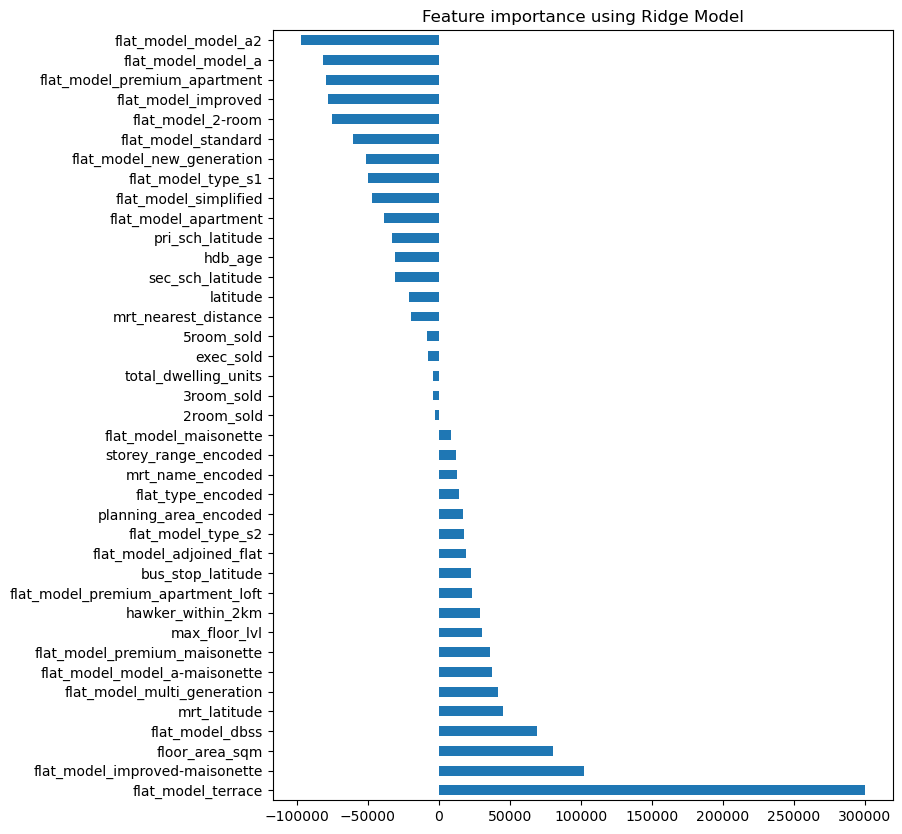

In [28]:
# graph to show the importance of variables in Ridge model
coef = pd.Series(ridge.coef_, index=X_val_2.columns).sort_values(ascending=False)
plt.rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model");

Flat model is the most influential variables in determination of resale price. Among the model, hdb terrace stand out to be the first that has highest sensitivity to the resale price. Hdb terrace was last built in the 1960s, with 99 year lease. It is a landed properties with a backyard, hence with a bigger built up area. The reason terrace flat model is sensitive to resale price are firstly, this is a rare model landed property that has much reasonable price compared to private landed house. Secondly, buyers could be looking for an en bloc windfall (Property Guru Editorial Team, 2021). However, Ryan (2021) highlighted that the hdb terrace might have higher depreciation rate as it near the last 20-30 year lease, mainly due to financing issue. Hence, it is worth noting that the prediction power of resale price for this flat model in the future might turn weaker.

Larger and rare flats in general associated with higher selling price. This is supported by article written by Property Guru Editorial Team (2022) that rare type of resale flat, such as an HDB maisonette or jumbo flat are highly in demand as it is not in production anymore. 

Ridge model shows a large coefficient positively related between mrt and resale price, and a large coefficient negatively related between pri sch and resale price. The plot below clearly shows the location of the different latitudes in Singapore. The larger the mrt latitude, towards the cluster at the north region, the higher resale price we can expect. This means that the higher resale price in north region is mainly due to the variable mrt. This could probably explained by Eugenia (2020) article that those regions with less accessibility tend to have greater appreciation with the opening of new mrt. Comparing to central region which are already high priced due to its prime location and better serviced by more bus routes and mrt stations, resale price in central region will have lower impact by the nearby mrt. The higher resale price is represented by darker color intensity. Therefore, the reason central region has higher resale price must be due to other variables.

Whereas the smaller the pri and sec school latitude, which is closer to the area around the singapore central region, the higher the resale price. There is no article or evidence to show the reason behind this, it could be explored further in other analysis.

The 10 mrt names, pri and sec school names that have the highest impact on resale price of nearby flat are listed for reference.


<font size = 2> Eugenia, L. (2020). How Does Distance to MRT Affect Property Prices in Singapore? Retrieved from https://www.propertyguru.com.sg/property-guides/mrt-effect-on-property-prices-39498
<font size = 2> Property Guru Editorial Team. (2021). HDB terrace houses: 6 of thesepublic landed properties under 1 million. Retrieved from https://www.propertyguru.com.sg/property-guides/cheap-hdb-terrace-house-under-850k-35237 \
<font size = 2>Property Guru Editorial Team. (2022). 3 Top Factors Affecting HDB Valuation in Singapore: What HDB Resale Buyers Need to Know. Retrieved from https://www.propertyguru.com.sg/property-guides/hdb-valuation-sales-12882 \
<font size = 2>Ryan. (2021). HDB landed terrace houses: 5 factors you must consider before buying one. Retrieved from https://stackedhomes.com/editorial/hdb-landed-terrace-houses-5-factors-you-must-consider-before-buying-one/#gs.qukkha 

In [29]:
#groupby mrt, pri sch and sec school latitude with resale price
mrt_price = hdb.groupby(["mrt_latitude", "mrt_longitude"])[["resale_price"]].median().sort_values(by="resale_price").reset_index()
pri_sch_price = hdb.groupby(["pri_sch_latitude", "pri_sch_longitude"])[["resale_price"]].median().sort_values(by="resale_price").reset_index()
sec_sch_price = hdb.groupby(["sec_sch_latitude", "sec_sch_longitude"])[["resale_price"]].median().sort_values(by="resale_price").reset_index()

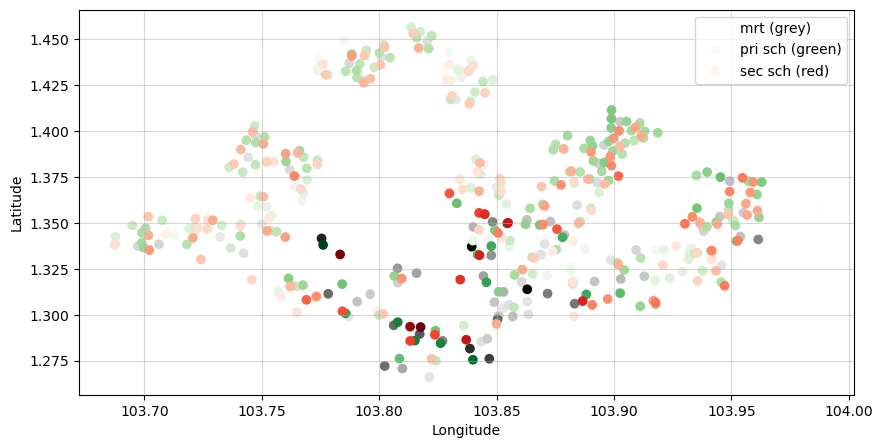

In [30]:
#scatter plot to have a sense of direction in terms of latitude
# and to analyse the resale price from low to high (darker color)

plt.figure(figsize=(10,5))
plt.scatter(x=mrt_price["mrt_longitude"], y=mrt_price["mrt_latitude"], c=mrt_price["resale_price"],
            cmap="Greys", marker='o', label="mrt (grey)")
plt.scatter(x=pri_sch_price['pri_sch_longitude'], y=pri_sch_price['pri_sch_latitude'], c=pri_sch_price["resale_price"],
            cmap="Greens", marker="o", label="pri sch (green)")
plt.scatter(x=sec_sch_price['sec_sch_longitude'], y=sec_sch_price['sec_sch_latitude'], c=sec_sch_price["resale_price"],
            cmap="Reds", marker="o", label="sec sch (red)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.5)
plt.show();

In [31]:
# higher resale price for flat with the 10 nearest mrt 
hdb.groupby("mrt_name")["mrt_latitude"].unique().sort_values(ascending=False).head(10)

mrt_name
Woodlands North    [1.4490567019999998]
Sembawang                 [1.448927331]
Canberra                  [1.443076641]
Admiralty          [1.4403433719999998]
Woodlands                 [1.437094408]
Marsiling                  [1.43275723]
Yishun                     [1.42940145]
Woodlands South           [1.427636527]
Khatib                    [1.417130546]
Punggol                   [1.405156551]
Name: mrt_latitude, dtype: object

In [32]:
# higher resale price for flat around the 10 primary schools
hdb.groupby("pri_sch_name")["pri_sch_latitude"].unique().sort_values().head(10)

pri_sch_name
Radin Mas Primary School       [1.274961612]
Cantonment Primary School      [1.275505441]
CHIJ                           [1.276029248]
Blangah Rise Primary School    [1.276130304]
Zhangde Primary School          [1.28449822]
Gan Eng Seng Primary School    [1.285955393]
Alexandra Primary School       [1.291299035]
River Valley Primary School    [1.294183475]
Queenstown Primary School      [1.295988446]
New Town Primary School        [1.299811388]
Name: pri_sch_latitude, dtype: object

In [33]:
# higher resale price for flat around the 10 secondary schools
hdb.groupby("sec_sch_name")["sec_sch_latitude"].unique().sort_values().head(10)

sec_sch_name
CHIJ Saint Theresa's Convent           [1.276029248]
Bukit Merah Secondary School           [1.285751537]
Outram Secondary School                [1.286387486]
Gan Eng Seng School                    [1.289071145]
Crescent Girls' School                 [1.293305114]
Queenstown Secondary School     [1.2935332940000002]
Raffles Girls' School                  [1.295013834]
Dunman High School                     [1.299125304]
Queensway Secondary School             [1.300475167]
Kent Ridge Secondary School            [1.301352887]
Name: sec_sch_latitude, dtype: object

# [CLICK TO CONCLUSION](#CONCLUSION)

# PLEASE IGNORE THIS PART BELOW AND SKIP TO CONCLUSION 

## Third Attempt on Modeling (Blindly fit in 50 continuos variables + encoded v.)

Polynomial features included all the continuos variables and target encoded variables. Those features are in the list of [scaling features], and data selected must have original scale before combining the different features.

In [34]:
# #instantiate polynomial 
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# #fit and transform features that can be scaled later
# X_poly = poly.fit_transform(hdb[scaling_features])

# #new dataframe created to incorporate all the new features created
# hdb_and_polynomial = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(scaling_features))

# #shape of new dataframe
# hdb_and_polynomial.shape

In [35]:
# # difference for column before and after creating new features
# hdb_and_polynomial.shape[1] - hdb[scaling_features].shape[1]

In [36]:
# #find the corr with "resale_price"
# corr = round(hdb_and_polynomial.corrwith(hdb["resale_price"]).sort_values(ascending=False),4)

# #create a dict to find absolute corr > 0.4
# corr_dict = {}
# for k,v in corr.iteritems():
#     if v>=0.4 or v<=-0.4:
#         corr_dict[k] = v

In [37]:
# #initiate with f-reg method and k=30
# select = SelectKBest(score_func=f_regression, k=50)

# #fit and transform all the continuos variables
# k_fit = select.fit(hdb_and_polynomial[[k for k in corr_dict]], hdb["resale_price"])
# k_transform = k_fit.transform(hdb_and_polynomial[[k for k in corr_dict]])

# #dataframe created to find best features among all the continuos variabes
# kept_features = pd.DataFrame({'columns': hdb_and_polynomial[[k for k in corr_dict]].columns,
#                               'Kept': k_fit.get_support()})
# kept_features = kept_features[kept_features["Kept"] == True]["columns"].tolist() 

# #the 30 best continuos features
# kept_features

In [38]:
# #X1, Y1 are new split of data with polynomial features
# #previous two attempts were using same train and split data
# X1 = pd.concat([hdb_and_polynomial[kept_features], hdb[eda_features]], axis=1)
# y1 = hdb["resale_price"]

# X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X1, y1, test_size=0.25, random_state=10)

In [39]:
# X1.shape

In [40]:
# # for continuos variables
# # and target-encoded variables ("planning_area_encoded", "mrt_name_encoded")

# #fit and transform train data
# ss_fit = ss.fit(X_train_3)
# X_train_3 = ss_fit.transform(X_train_3)

# #tranform only val data
# X_val_3 = ss.transform(X_val_3)

In [41]:
# #linear regression
# lr = LinearRegression()
# lr.fit(X_train_3, y_train_3)
# lr_y_pred = lr.predict(X_val_3)

# #ridge regression
# ridge = RidgeCV(alphas=(0.1,50,1000))
# ridge.fit(X_train_3, y_train_3)
# ridge_y_pred = ridge.predict(X_val_3)

# #lasso regression
# lasso = LassoCV(n_alphas=200, cv=5, max_iter=50000)
# lasso.fit(X_train_3, y_train_3)
# lasso_y_pred = lasso.predict(X_val_3)

In [42]:
# #linear regression
# print("Linear Regression:\n")
# print(f'R2 score for training set: {lr.score(X_train_3, y_train_3):.4f}')
# print(f'R2 score for validation set: {lr.score(X_val_3, y_val_3):.4f}')
# print(f'Cross Val Score: {cross_val_score(lr, X_train_3, y_train_3, cv=5).mean():.4f}')

# print("\n")

# #ridge regression
# print("Ridge Regression:\n")
# print(f'R2 score for training set: {ridge.score(X_train_3, y_train_3):.4f}')
# print(f'R2 score for validation set: {ridge.score(X_val_3, y_val_3):.4f}')
# print(f'Cross Val Score: {cross_val_score(ridge, X_train_3, y_train_3, cv=5).mean():.4f}')

# print("\n")

# #linear regression
# print("Lasso Regression:\n")
# print(f'R2 score for training set: {lasso.score(X_train_3, y_train_3):.4f}')
# print(f'R2 score for validation set: {lasso.score(X_val_3, y_val_3):.4f}')
# print(f'Cross Val Score: {cross_val_score(lasso, X_train_3, y_train_3, cv=5).mean():.4f}')

In [43]:
# #linear regression
# print("Linear Regression:")
# print(f'RMSE for training set: {metrics.mean_squared_error(y_train_3, lr.predict(X_train_3), squared=False):.4f}')
# print(f'RMSE for validation set: {metrics.mean_squared_error(y_val_3, lr.predict(X_val_3), squared=False):.4f}')
# print(f'Cross Val Score: {cross_val_score(lr, X_train_3, y_train_3, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

# print("\n")

# #ridge regression
# print("Ridge Regression:")
# print(f'RMSE for training set: {metrics.mean_squared_error(y_train_3, ridge.predict(X_train_3), squared=False):.4f}')
# print(f'RMSE for validation set: {metrics.mean_squared_error(y_val_3, ridge.predict(X_val_3), squared=False):.4f}')
# print(f'Cross Val Score: {cross_val_score(ridge, X_train_3, y_train_3, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

# print("\n")

# #lasso regression
# print("Lasso Regression:")
# print(f'RMSE for training set: {metrics.mean_squared_error(y_train_3, lasso.predict(X_train_3), squared=False):.4f}')
# print(f'RMSE for validation set: {metrics.mean_squared_error(y_val_3, lasso.predict(X_val_3), squared=False):.4f}')
# print(f'Cross Val Score: {cross_val_score(lasso, X_train_3, y_train_3, cv=5, scoring="neg_root_mean_squared_error").mean()*-1:.4f}')

<a id='CONCLUSION'></a>
## Conclusion

### Scores

| Model | CV R2 Score (Train) | CV RMSE (Train) | 
| --- | --- | --- |
| Baseline Model | 0.4453 | 106873.66 |
| --- | --- | --- |
| OLS using EDA feature selection| 0.7734 | 68205.74 |
| Ridge Regression using EDA feature selection | 0.7734 | 68205.58 |
| Lasso Regression using EDA feature selection | 0.7713 | 68519.83 |
| --- | --- | --- |
| OLS using K-best (k=15, f-reg)| 0.8350 | 58200.76 |
| Ridge Regression using K-best (k=15, f-reg)| 0.8350 |58200.69|
| Lasso Regression using K-best (k=15, f-reg)| 0.8329 |58562.00| 
| --- | --- | --- |
| Kaggle Submission Score (public)| -|57657.40| 
| Kaggle Submission Score (private)| -|59412.28| 

Ridge model using K-best feature selection is the best model to predict the price of HDB resale flat with minimal errors and high accuracy, represented by highest R2 score and lowest RMSE. This model has been significantly improved from baseline model that has 44% R2 score and the models with lesser variables selected during EDA process that has 77% accuracy score.

Ridge model trades variance for bias. It is usually better than OLS when there are a large number of variables included because it has a penalty term to reduce overfitting and improve generalization to the testing set. However, one should notice that these two models have the same R2 score and just a few cents difference in average prediction error (RMSE). Both are working well and it mean that the variables included are mostly important and no overfitting, so penalizing effect imposed from ridge model is rather weak. This could also mean that the prediction power still has room for improvement by adding more variables to capture more signals.

Ridge model has lesser error compared to Lasso model is because Lasso tends to work well when there are only a handful of true predictors. Since in this case the selected variables are appropriate, its penalty effect to reduce coefficients that are highly correlated into zero turns the model to have higher variance than other models as it missing some important signals. This is the limitation of LASSO where it is unable to do group selection. If there is a group of variables among which the pairwise correlations are very high, then the LASSO tends to arbitrarily select only one variable from the group. That is the reason it turns most of the one-hot encoded variables into zero, and with less signal in the model, it performs slightly worse than Ridge model.

In accordance to the coefficients in the best model in this project, the order of importance in ascending order is as follow: flat model (particularly terrance), floor area in sqm, mrt latitude (similar to mrt name), pri school latitude, hdb age, sec school latitude, max floor lvl, hawker within 2km, bus stop latitude, latitude based on postal code, mrt nearest distance, planning area, flat type.

## Recommendation and Limitation

Although the R2 score is above 80%, there is room for improvement, this could be done by adding model complexity to capture as much signals as possible. One of the recommendation is to include GDP and interest rate datasets to analyse the trend of the resale price because macroeconomic factors could have a large impact on resale price. The demand and supply of resale flat and the upward and downward trend in the resale price over the years fluctuates as seen in the EDA process. Additionally, polynomial features should be analysed to examine their combination effect on resale price.

Also, target encoding has been applied to mrt name and planning area. It could be improved by taken into consideration the weight based on the count of the groups to be a more accurate indicator. Also, a number of outliers have been observed in the EDA process, and this should be removed or eliminated in order to generalize the effect on resale price. While standard scaler is highly influenced by outliers, robust scaling is recommended for better measurement.

## Test Data Set (Submit on Kaggle)

##### Load Data

In [44]:
#load data
X_test = pd.read_csv("../data/test.csv")

# Convert all columns to lowercase and replace spaces in column names.
X_test.columns = X_test.columns.str.lower().str.replace(' ', '_')

C:\Users\szehu\AppData\Local\Temp\ipykernel_4448\2295356704.py:2: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv("../data/test.csv")


##### Null Value

In [45]:
#check null value
null_features = []
check_null = X_test.isnull().sum().sort_values(ascending=False)
for key,value in check_null.iteritems():
    if value != 0:
        null_features.append(key)
        print(key,":",value)

#check if there is 0 in the respective features, if not then assume it meant 0
X_test[X_test[null_features].values == 0]

hawker_within_500m : 10755
mall_within_500m : 10292
hawker_within_1km : 6729
hawker_within_2km : 3254
mall_within_1km : 2786
mall_within_2km : 213
mall_nearest_distance : 84


,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
511,114882,2012-07,WOODLANDS,5 ROOM,680,WOODLANDS AVE 6,04 TO 06,123.0,Improved,1998,...,61,0,1.44011,103.804629,429.86362,Woodlands Ring Secondary School,211,0,1.436114,103.800521


In [46]:
# fillna with zero for the above 7 features with no "zero value"
for feature in null_features:
    X_test[feature] = X_test[feature].fillna(0)
    
#double check null value
X_test.isnull().sum().value_counts()

0    76
dtype: int64

##### Duplicated Row

In [47]:
#check of duplicate rows
X_test.duplicated().sum()

0

##### Preprocessing: Encode "storey_range"

In [48]:
# encode "lower" to 4 groups

def storey_range(x):
    if x <= 4:
        return 0
    elif x <= 7:
        return 1
    elif x <= 10:
        return 2
    else:
        return 3   
    
X_test["storey_range_encoded"] = X_test["lower"].map(storey_range)

##### Preprocessing: Encode "flat_type"

In [49]:
# encode "flat_type" to 0-6 (represent small to large size), and then drop the original column

scale_mapper = {"1 ROOM":0, "2 ROOM":1, "3 ROOM":2, "4 ROOM":3, "5 ROOM":4, "EXECUTIVE":5, "MULTI-GENERATION":6}
X_test["flat_type_encoded"] = X_test["flat_type"].map(scale_mapper)

##### Preprocessing: One-Hot Encoding for variable "flat_model"

In [50]:
#fit the encoding
transformed = ohe.fit_transform(X_test[["flat_model"]])

#construct a dataframe for ohe columns
columnname = ohe.get_feature_names_out(["flat_model"])
transformed_df = pd.DataFrame(transformed, columns=columnname)

#lowercase and replace empty space in column name
transformed_df.columns = transformed_df.columns.str.lower().str.replace(' ', '_')

#concat the ohe dataframe into X_test dataframe
X_test = pd.concat([X_test, transformed_df], axis=1)

##### Preprocessing: Target Encoding for variable "planning_area"

In [51]:
#create a column to store encoded value
X_test["planning_area_encoded"] = te_fit_pa.transform(X_test["planning_area"])

##### Preprocessing: Target Encoding for variable "mrt_name"

In [52]:
#create a column to store encoded value
X_test["mrt_name_encoded"] = te_fit_mrt.transform(X_test["mrt_name"])

##### Preprocessing: Scaling

In [53]:
# for continuos variables
# and target-encoded variables ("planning_area_encoded", "mrt_name_encoded")

scaling_features = ['floor_area_sqm', 'tranc_year', 'tranc_month', 'hdb_age', 'max_floor_lvl', 
                      'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
                      '4room_sold', '5room_sold', 'exec_sold','multigen_sold', 'studio_apartment_sold',
                      '1room_rental', '2room_rental','3room_rental', 'other_room_rental', 'latitude',
                      'longitude','mall_within_500m', 'mall_within_1km', 'mall_within_2km',
                      'hawker_nearest_distance', 'hawker_within_500m','hawker_within_1km',
                      'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
                      'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange', 'mrt_latitude',
                      'mrt_longitude', 'bus_stop_nearest_distance', 'bus_stop_latitude', 'bus_stop_longitude',
                      'pri_sch_nearest_distance', 'vacancy','pri_sch_latitude', 'pri_sch_longitude',
                      'sec_sch_nearest_dist', 'cutoff_point', 'sec_sch_latitude', 'sec_sch_longitude',
                       'planning_area_encoded', 'mrt_name_encoded']

#fit the scaler
X_test[scaling_features] = ss.transform(X_test[scaling_features])

##### Column and Order Check

In [54]:
#check column not present in test dataset
for x in X_train_2.columns:
    if x not in X_test.columns:
        print(x)

flat_model_2-room


In [55]:
#add a column and fill with 0 in the disappear one hot encoded column
X_test["flat_model_2-room"] = 0

In [56]:
#align the column order in accordance to X train (2nd attempt) columns
X_test_final =  X_test[X_train_2.columns]

##### Prediction

In [57]:
#prediction on test data using best model - ridge model
ridge_y_pred = ridge.predict(X_test_final)

In [58]:
#confirm number of row

print(X_test.shape)
print(ridge_y_pred.shape)

(16737, 100)
(16737,)


In [59]:
#create dataframe and input "id" and "prediction" for submission
kaggle_pred = pd.DataFrame(columns=["Id", "Predicted"])
kaggle_pred["Id"] = X_test["id"]
kaggle_pred["Predicted"] = ridge_y_pred

kaggle_pred

,Id,Predicted
0,114982,315245.113292
1,95653,522619.899240
2,40303,332721.608233
3,109506,332963.732754
4,100149,443656.584551
...,...,...
16732,23347,334936.314882
16733,54003,492757.632570
16734,128921,439948.129740
16735,69352,500860.461315


In [60]:
#save as csv
# kaggle_pred.to_csv("../data/kaggle_pred.csv")